# Image Classification

adpated from: [Kaggle Face Mask Detection](https://www.kaggle.com/mirzamujtaba/face-mask-detection)

Other references:
[Keras Image Classification from Scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img

from bs4 import BeautifulSoup

Using TensorFlow backend.


datagen = Image

# 1_Dictionary of Faces

In [2]:
images= []
path = 'ignore/KaggleTrainImgs/images/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        images.append(load_img(path + filename))

In [3]:
len(images)

853

In [4]:
#face coordinates
def generate_box(obj):  
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return[xmin,ymin,xmax,ymax]

In [5]:
#label converted to numbers
def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "no_mask": #changed from mask_weared_incorrect
        return 2
    return 0

In [6]:
#Using in this main function we parse the annotations file and get the objects out from them
# Also we use the above two functions here 
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
            
        boxes=np.array(boxes)
        labels=np.array(labels)
        
        img_id = np.array(image_id)
        
    # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return (target,num_objs)

In [7]:
# Here we use the above functions and save results in lists
targets=[]#store coordinates
numobjs=[]#stores number of faces in each image
#run the loop for number of images we have
for i in range(853):
    file_image = 'maksssksksss'+ str(i) + '.png'
    file_label = 'maksssksksss'+ str(i) + '.xml'
    img_path = os.path.join("ignore/KaggleTrainImgs/images/", file_image)
    label_path = os.path.join("ignore/KaggleTrainImgs/annotations/", file_label)
    #Generate Label
    target,numobj = generate_target(i, label_path)
    targets.append(target)
    numobjs.append(numobj)
    

# 2_Preprocessing Dictionary

In [8]:
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

In [9]:
face_images=[]
face_labels=[]

for i in range(853):
    img_path = r"ignore/KaggleTrainImgs/images/maksssksksss{}.png".format(i)
    #read image
    img = cv2.imread(img_path)
    for j in range(numobjs[i]):
#       get coordinates of ith image in list 
        locs=(targets[i]['boxes'][j])
#     Get the face from the image using the coordinates
#the arguments are as ymin , ymax and xmin xmax
        img1=img[locs[1]:locs[3],locs[0]:locs[2]]
        img1 = cv2.resize(img1, (224, 224))
        img1 = img_to_array(img1)
        img1 = preprocess_input(img1)
        face_images.append(img1)
        face_labels.append(targets[i]['labels'][j])

face_images= np.array(face_images, dtype="float32")
face_labels = np.array(face_labels)

In [10]:
len(face_labels)

4072

In [11]:
unique, counts = np.unique(face_labels, return_counts=True)
dict(zip(unique, counts))

{0: 840, 1: 3232}

In [12]:
#One Hot encode labels
lb = LabelEncoder()
labels = lb.fit_transform(face_labels)
labels = to_categorical(labels)
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [13]:
#Perform data augmentation = creates mutliple pictures based on single picture by flipping, cropping etc.
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
    )

# 3_Model

In [14]:
from keras.applications import MobileNetV2
from keras import Model
from keras.layers import AveragePooling2D,Flatten,Dense,Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [20]:
#define the model
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3)) #keras available model which is the base

# construct the head of the model that will be placed on top of the base model
#keras.layers "activate" the neural network to spark, ie. do something, it is required to run the model.
headModel = baseModel.output #head starts with the MobileNetV2 base
headModel = AveragePooling2D(pool_size=(7, 7))(headModel) #decreases the size of the data
headModel = Flatten(name="flatten")(headModel) #converts 2D to 1D
headModel = Dense(256, activation="relu")(headModel) #hidden layers on output layer, helps create layers, 
#relu - applies the rectivied linear unti activation function.
headModel = Dropout(0.25)(headModel) #drops out extra means so it doesn't learn "exactly"
headModel = Dense(2, activation="softmax")(headModel)  #softmax = converts a real vector to a vector of categorical probabilities, sum to 1

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [21]:
#hyperparams
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [22]:
(X_train,X_test,y_train,y_test) = train_test_split(face_images,labels,test_size=0.2,stratify=labels,random_state=42)

In [25]:
# ___May need to run if running out of space___

del targets,face_images, face_labels


In [26]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS) #model for gradient descent based on randomly adaptive estimation of 
#first_order (mean for the averages) and second-order (variance for the avgs of squared gradients) moments
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) #like pipeline but can't gridsearch, used to compile pieces togther.

# train the head of the network
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10}) #Ea class has it's own weight, class w/ highest weight will be more important 


Epoch 1/20
101/101 [==============================] - 296s 3s/step - loss: 0.7303 - accuracy: 0.7988 - val_loss: 0.4239 - val_accuracy: 0.8368
Epoch 2/20
101/101 [==============================] - 271s 3s/step - loss: 0.6688 - accuracy: 0.8198 - val_loss: 0.5407 - val_accuracy: 0.7215
Epoch 3/20
101/101 [==============================] - 252s 2s/step - loss: 0.6125 - accuracy: 0.8384 - val_loss: 0.4607 - val_accuracy: 0.8037
Epoch 4/20
101/101 [==============================] - 257s 3s/step - loss: 0.6359 - accuracy: 0.8301 - val_loss: 0.4558 - val_accuracy: 0.8012
Epoch 5/20
101/101 [==============================] - 245s 2s/step - loss: 0.5809 - accuracy: 0.8487 - val_loss: 0.4458 - val_accuracy: 0.8037
Epoch 6/20
101/101 [==============================] - 253s 3s/step - loss: 0.5824 - accuracy: 0.8518 - val_loss: 0.4704 - val_accuracy: 0.7914
Epoch 7/20
101/101 [==============================] - 270s 3s/step - loss: 0.5595 - accuracy: 0.8499 - val_loss: 0.4795 - val_accuracy: 0.7828

# Evaluate & Save Model

In [28]:
from sklearn.metrics import classification_report

In [29]:
#evaluate model
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.58      0.45      0.50       168
           1       0.86      0.91      0.89       647

    accuracy                           0.82       815
   macro avg       0.72      0.68      0.70       815
weighted avg       0.81      0.82      0.81       815



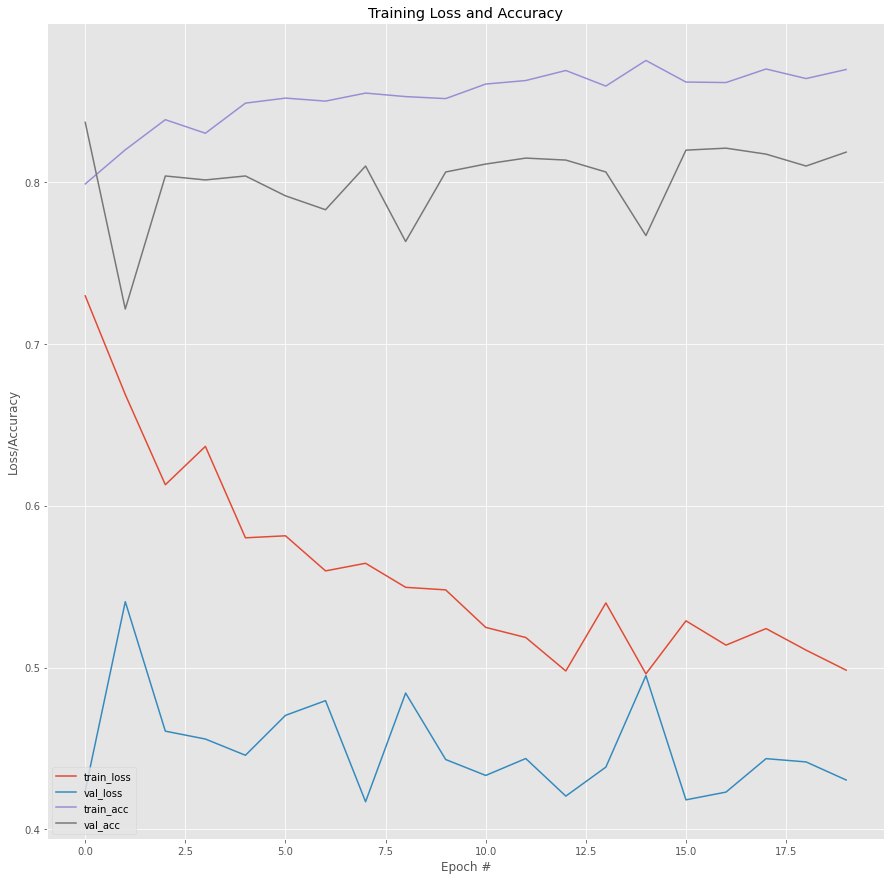

In [32]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,15))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [33]:
model.save('MA_imgclass')

# Train model again

In [34]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS,
class_weight = {0:5 , 1:1, 2:10})

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
101/101 [==============================] - 304s 3s/step - loss: 0.5072 - accuracy: 0.8676 - val_loss: 0.4743 - val_accuracy: 0.8172
Epoch 2/20
101/101 [==============================] - 284s 3s/step - loss: 0.4648 - accuracy: 0.8843 - val_loss: 0.4595 - val_accuracy: 0.8049
Epoch 3/20
101/101 [==============================] - 274s 3s/step - loss: 0.4860 - accuracy: 0.8750 - val_loss: 0.4644 - val_accuracy: 0.8172
Epoch 4/20
101/101 [==============================] - 375s 4s/step - loss: 0.4747 - accuracy: 0.8763 - val_loss: 0.4607 - val_accuracy: 0.8123
Epoch 5/20
101/101 [==============================] - 319s 3s/step - loss: 0.4452 - accuracy: 0.8806 - val_loss: 0.4340 - val_accuracy: 0.8147
Epoch 6/20
101/101 [==============================] - 275s 3s/step - loss: 0.4500 - accuracy: 0.8778 - val_loss: 0.4435 - val_accuracy: 0.8184
Epoch 7/20
101/101 [==============================] - 366s 4s/step - loss: 0.4552 - accuracy

# Evaluate the Model again

In [36]:
#evaluate model
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=32)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predIdxs))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.55      0.22      0.31       168
           1       0.82      0.95      0.88       647

    accuracy                           0.80       815
   macro avg       0.69      0.59      0.60       815
weighted avg       0.77      0.80      0.77       815



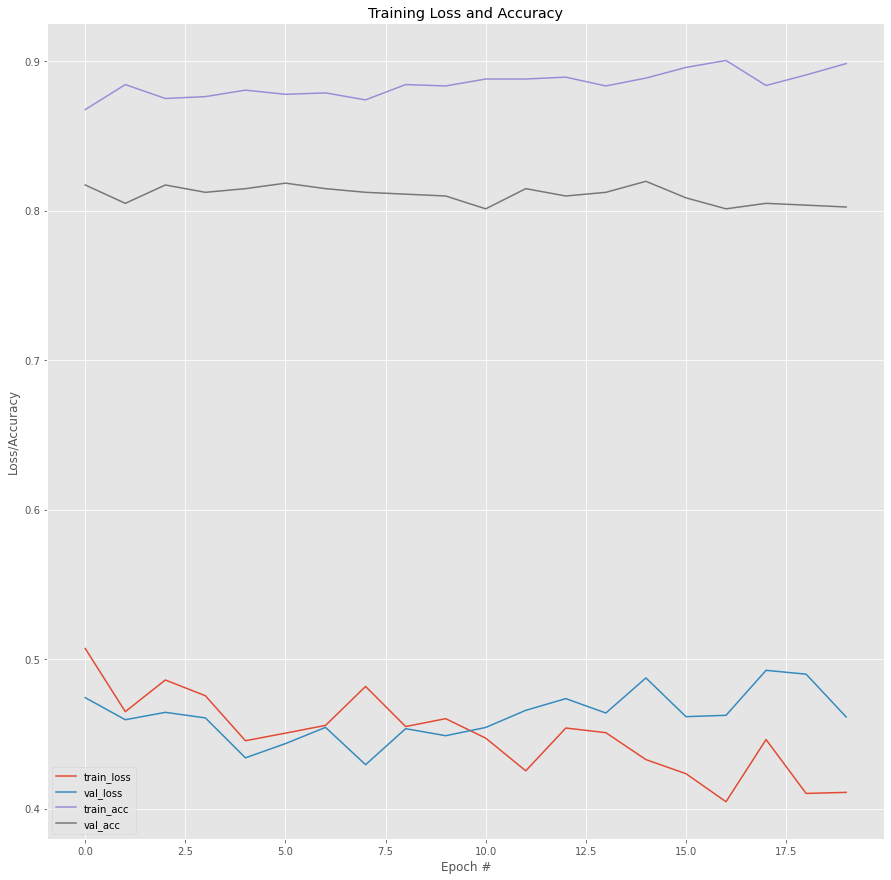

In [37]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,15))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()